In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import math

from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score

from sklearn.ensemble import GradientBoostingRegressor
# feature selection (from supportive model)
from sklearn.feature_selection import SelectFromModel
from sklearn.grid_search import GridSearchCV


import xgboost as xgb


/Users/adityavyas/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/adityavyas/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

## Encoding Categorical Variables

In [3]:
for col in train.select_dtypes(['object']).columns:
    lb=LabelEncoder()
    lb.fit(list(train[col].values.astype(str))+list(test[col].values.astype(str)))
    train[col]=lb.transform(list(train[col].astype(str)))
    test[col]=lb.transform(list(test[col].astype(str)))
    print col, 'Done'

X0 Done
X1 Done
X2 Done
X3 Done
X4 Done
X5 Done
X6 Done
X8 Done


## Feature Importance

In [4]:
x_train=train.drop(['y','ID'],1)
y_train=train['y']

xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
dtrain = xgb.DMatrix(x_train, y_train, feature_names=x_train.columns.values)
model = xgb.train(dict(xgb_params, silent=1), dtrain, num_boost_round=100)

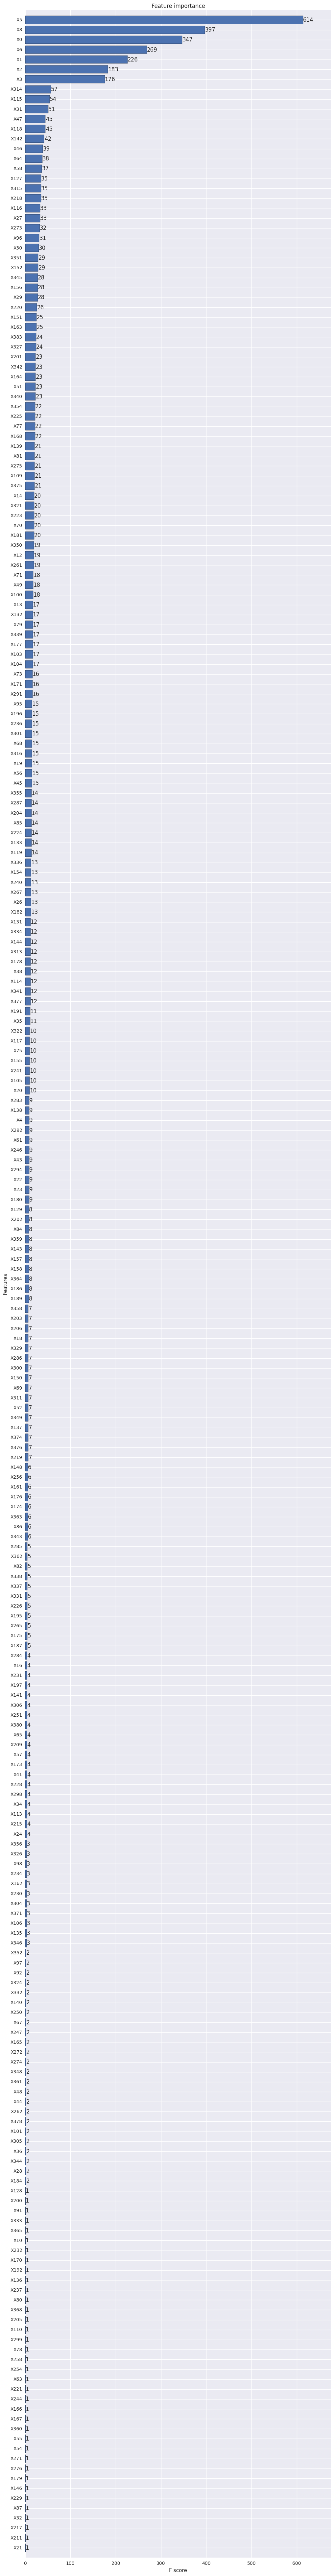

In [5]:
fig, ax = plt.subplots(figsize=(12,100))
xgb.plot_importance(model, height=0.8, ax=ax)
plt.show()

## Number of Binary values
One feature I will create is the number of binary values per row/data point

In [6]:
for index in train.index:
    train.ix[index, 'ones_count']=len(train.ix[index][train.ix[index]==1])
    train.ix[index, 'zeros count']=len(train.ix[index][train.ix[index]==0])
    
    test.ix[index, 'ones_count']=len(test.ix[index][test.ix[index]==1])
    test.ix[index, 'zeros count']=len(test.ix[index][test.ix[index]==0])
    
train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X377,X378,X379,X380,X382,X383,X384,X385,ones_count,zeros count
0,0,130.81,37,23,20,0,3,27,9,14,...,1,0,0,0,0,0,0,0,52.0,318.0
1,6,88.53,37,21,22,4,3,31,11,14,...,0,0,0,0,0,0,0,0,52.0,316.0
2,7,76.26,24,24,38,2,3,30,9,23,...,0,0,0,0,1,0,0,0,73.0,295.0
3,9,80.62,24,21,38,5,3,30,11,4,...,0,0,0,0,0,0,0,0,62.0,306.0
4,13,78.02,24,23,38,5,3,14,3,13,...,0,0,0,0,0,0,0,0,58.0,310.0


## Cross-Validation
First I will use all the features and then reduce the features depending on the importance

In [7]:
training, validation = train_test_split(train, test_size=0.2, random_state=4242)

test_ids=test['ID']

#We first select all the features
x_train1, y_train1 = training.drop(['y'],1), training['y']
x_val1, y_val1 = validation.drop(['y'],1), validation['y']
x_test=test
training.shape, validation.shape

((3367, 380), (842, 380))

We first create baseline models and train a simple linear regression model

## Linear Regression 

In [8]:
lr1=LinearRegression(normalize=False, fit_intercept=True)
lr1.fit(x_train1, y_train1)
pred1=lr1.predict(x_val1)
print r2_score(pred1, y_val1)

0.447435785118


/Users/adityavyas/anaconda/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


We see that the basic Linear regression gives a score of **0.4455**. Let us make a basic submission with this model.

In [9]:
lr1.fit(train.drop(['ID','y'],1), train['y'])
sub1=lr1.predict(test.drop('ID',1))
output_lr = pd.DataFrame({'id': test['ID'].astype(np.int32), 'y': sub1})
# output.to_csv('/mercedes.csv', index=False)

We get a public score of **0.51**
Let us take only a few important features.

In [10]:
imp_features=['X0','X5','X8','X6','X1','X2','X3','y']

x_train2, y_train2 = training[imp_features].drop('y',1), training[imp_features]['y']
x_val2, y_val2 = validation[imp_features].drop('y',1), validation[imp_features]['y']

lr2=LinearRegression(normalize=True, fit_intercept=True)
lr2.fit(x_train2, y_train2)
pred2=lr2.predict(x_val2)
print r2_score(y_val2, pred2)

0.0710857027716


This gives a very bad score. We need to reduce the dimensionality of the features

## PCA

/Users/adityavyas/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


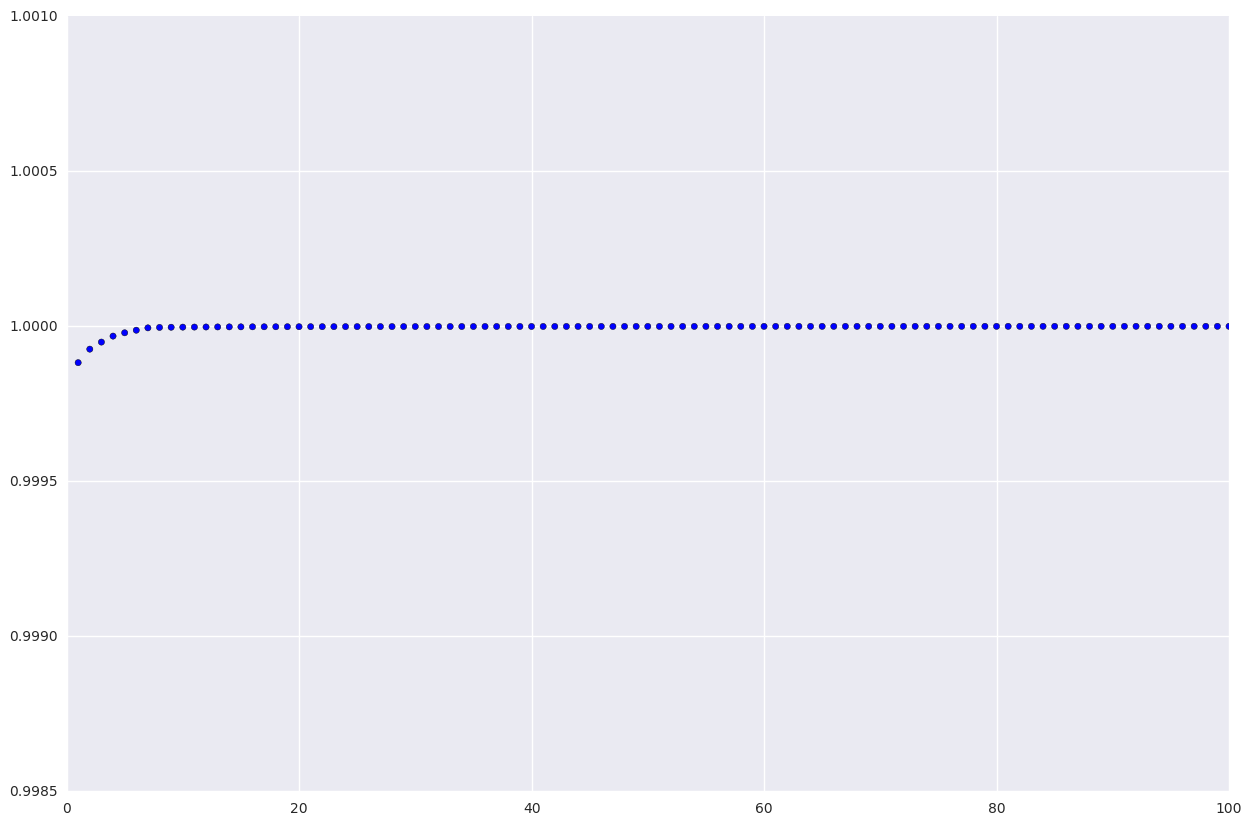

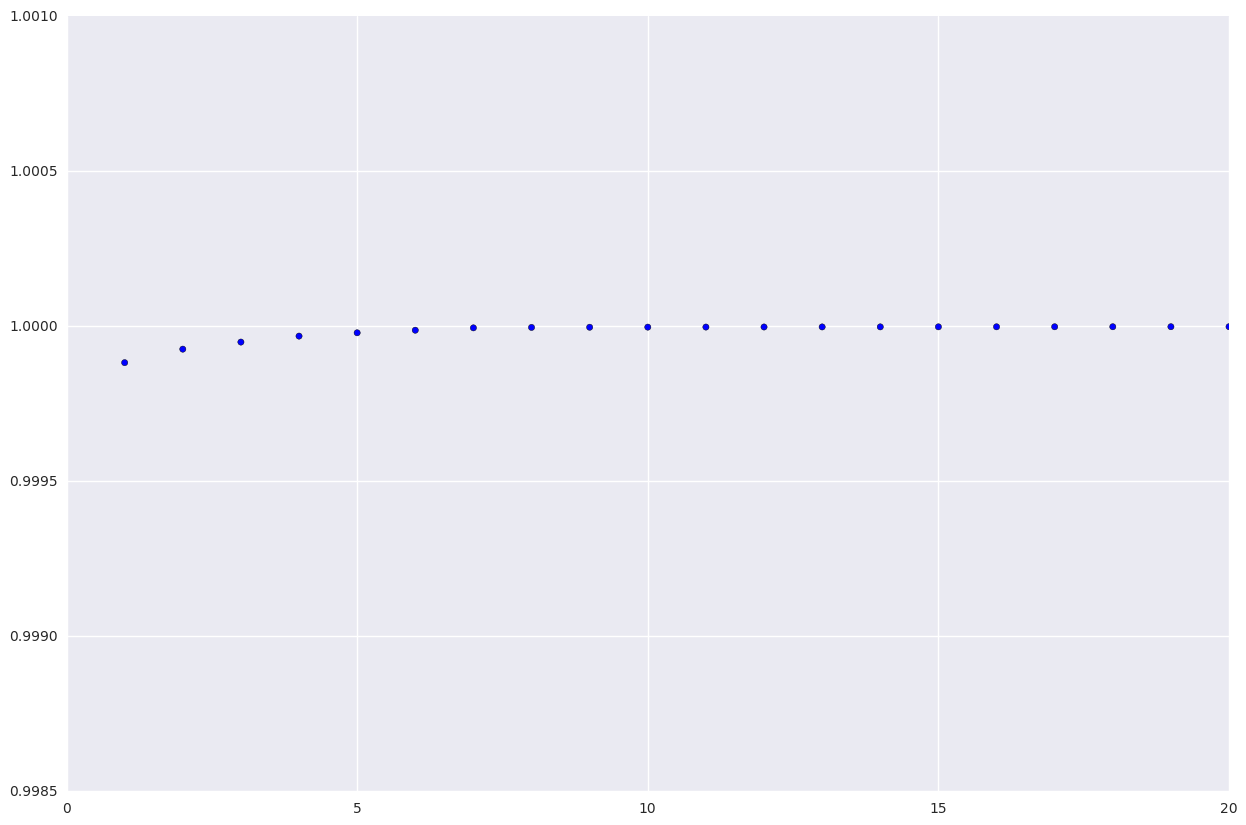

In [11]:
from sklearn.decomposition import PCA

full_data=pd.concat((train.drop(['y'],1), test), keys=['train', 'test'])

pca=PCA()
pca.fit(full_data)


plt.figure(1,figsize=(15,10))
list_k=range(1, (len(full_data.columns))+1)
# len(pca.explained_variance_ratio_.cumsum())
plt.scatter(list_k,pca.explained_variance_ratio_.cumsum())
plt.xlim([0,100])

plt.figure(2,figsize=(15,10))
plt.scatter(list_k,pca.explained_variance_ratio_.cumsum())
plt.xlim([0,20])
plt.show()

We now use a GridSearch to select the best number of components and create a pipeline to make our predictions.

## PCA + Linear Regression

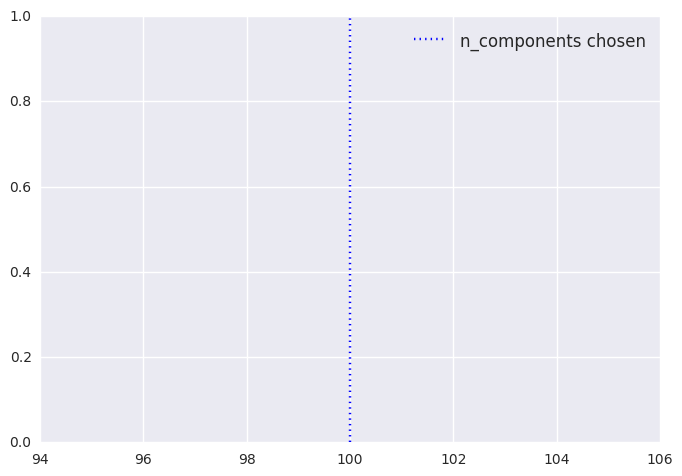

In [12]:
from sklearn.pipeline import Pipeline

X_TRAIN, Y_TRAIN = train.drop(['y'],1), train['y']
X_TEST = test
n_components = [50, 100, 200]

lr_pca = LinearRegression()
pca = PCA()
pipe = Pipeline(steps=[('pca', pca), ('linear', lr_pca)])

estimator = GridSearchCV(pipe,dict(pca__n_components=n_components))

estimator.fit(X_TRAIN, Y_TRAIN)

plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()

In [13]:
sub4=estimator.predict(test)
output_pca_lr = pd.DataFrame({'id': test['ID'].astype(np.int32), 'y': sub4})
# output_.to_csv('/Users/adityavyas/Desktop/mercedes4.csv', index=False)

This got me an LB score of **0.53**.

## PCA + Ridge Regression

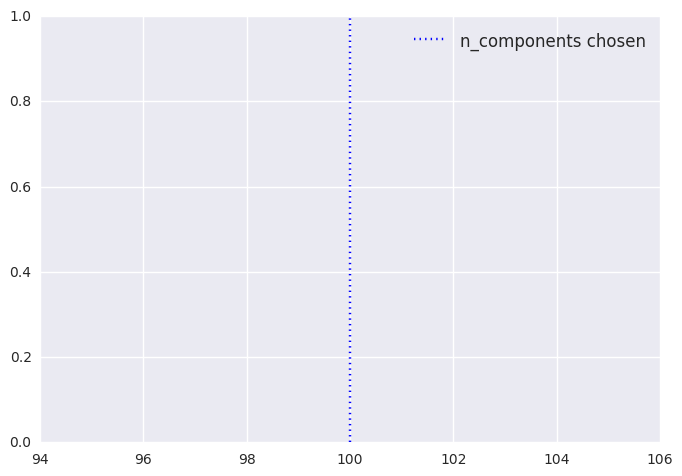

In [14]:
n_components = [50, 100, 200]

lr_ridge = Ridge()
pca = PCA()
pipe = Pipeline(steps=[('pca', pca), ('linear', lr_ridge)])

estimator_ridge = GridSearchCV(pipe,dict(pca__n_components=n_components))

estimator.fit(X_TRAIN, Y_TRAIN)

plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()


In [15]:
estimator_ridge.fit(x_train1, y_train1)
y_pred_ridge=estimator_ridge.predict(x_val1)
print r2_score(y_val1, y_pred_ridge)

0.614325835147


In [16]:
estimator_ridge.fit(train.drop(['ID','y'],1), train['y'])
sub6=estimator_ridge.predict(test.drop('ID',1))
output_pca_ridge = pd.DataFrame({'id': test['ID'].astype(np.int32), 'y': sub6})
# output.to_csv('/Users/adityavyas/Desktop/mercedes6.csv', index=False)

**One important observation is that a very high validation score is highly overfitting the data. A score of 0.44, 0.47 is likely to get you in the top of public LB. Whenever my validation crosses 0.51 or reaches 0.59, 0.61 I see a drop in my LB score**

## XGBoost

In [17]:

X_TRAIN, Y_TRAIN = train.drop(['y'],1), train['y']
X_TEST = test
X_train, X_val, Y_train, Y_val = train_test_split(X_TRAIN,Y_TRAIN, test_size=0.2, random_state=4242)


xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

d_train = xgb.DMatrix(X_train, label=Y_train)
d_val = xgb.DMatrix(X_val, label=Y_val)

watchlist = [(d_train, 'train'), (d_val, 'validation')]

bst1 = xgb.train(xgb_params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-rmse:96.1362	validation-rmse:95.2464
Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.

Will train until validation-rmse hasn't improved in 50 rounds.
[10]	train-rmse:58.0694	validation-rmse:57.1017
[20]	train-rmse:35.4936	validation-rmse:34.393
[30]	train-rmse:22.3932	validation-rmse:21.1252
[40]	train-rmse:14.9628	validation-rmse:13.6786
[50]	train-rmse:10.9249	validation-rmse:9.82121
[60]	train-rmse:8.86198	validation-rmse:8.05141
[70]	train-rmse:7.86715	validation-rmse:7.36461
[80]	train-rmse:7.31359	validation-rmse:7.17718
[90]	train-rmse:6.87548	validation-rmse:7.16236
[100]	train-rmse:6.64628	validation-rmse:7.18798
[110]	train-rmse:6.38461	validation-rmse:7.22891
[120]	train-rmse:6.12326	validation-rmse:7.26197
[130]	train-rmse:5.87665	validation-rmse:7.28988
Stopping. Best iteration:
[83]	train-rmse:7.19334	validation-rmse:7.15462



In [18]:
d_test = xgb.DMatrix(X_TEST)
sub_xgb=bst1.predict(d_test)
output_xgb = pd.DataFrame({'id': test['ID'].astype(np.int32), 'y': sub_xgb})
# output.to_csv('/Users/adityavyas/Desktop/mercedes_xgb.csv', index=False)

## PCA + XGBoost

In [20]:
pca=PCA(n_components=100)
train_new=train.copy()
test_new=test.copy()

train_labels=train_new.y

train_new=train_new.drop(['y'],1)
test_new=test_new

pca.fit(train_new+test_new)

train_pca=pca.transform(train_new)
test_pca=pca.transform(test_new)

x_train_pca, y_train_pca=train_pca, train_labels
X_TRAIN_PCA, X_VAL_PCA, Y_TRAIN_PCA, Y_VAL_PCA = train_test_split(x_train_pca,y_train_pca, test_size=0.2, random_state=4242)

X_TEST_PCA=test_pca

In [21]:
y_mean=np.mean(train_labels)

def xgb_r2_score(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)


xgb_params_pca = {
    'eta': 0.06,
    'max_depth': 8,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'base_score': y_mean,
    'silent': 1
}

d_train_pca = xgb.DMatrix(X_TRAIN_PCA, label=Y_TRAIN_PCA)
d_val_pca = xgb.DMatrix(X_VAL_PCA, label=Y_VAL_PCA)

watchlist = [(d_train_pca, 'train'), (d_val_pca, 'validation')]

bst_pca = xgb.train(xgb_params_pca, d_train_pca, 1500, watchlist, early_stopping_rounds=50, verbose_eval=10, 
                    feval=xgb_r2_score, maximize=True)

[0]	train-rmse:12.4241	validation-rmse:11.4566	train-r2:0.068037	validation-r2:0.06698
Multiple eval metrics have been passed: 'validation-r2' will be used for early stopping.

Will train until validation-r2 hasn't improved in 50 rounds.
[10]	train-rmse:9.27415	validation-rmse:8.90646	train-r2:0.480699	validation-r2:0.436113
[20]	train-rmse:7.51695	validation-rmse:7.97973	train-r2:0.658842	validation-r2:0.547354
[30]	train-rmse:6.34348	validation-rmse:7.70775	train-r2:0.757044	validation-r2:0.577684
[40]	train-rmse:5.5504	validation-rmse:7.64672	train-r2:0.813997	validation-r2:0.584346
[50]	train-rmse:4.95825	validation-rmse:7.6465	train-r2:0.851568	validation-r2:0.58437
[60]	train-rmse:4.51167	validation-rmse:7.64959	train-r2:0.877102	validation-r2:0.584034
[70]	train-rmse:4.12667	validation-rmse:7.67328	train-r2:0.897181	validation-r2:0.581453
[80]	train-rmse:3.7421	validation-rmse:7.69574	train-r2:0.915452	validation-r2:0.578999
[90]	train-rmse:3.46467	validation-rmse:7.71574	train-

In [22]:
d_test_pca = xgb.DMatrix(X_TEST_PCA)
sub_xgb3=bst_pca.predict(d_test_pca)
output_xgb3 = pd.DataFrame({'id': test['ID'].astype(np.int32), 'y': sub_xgb3})
output_xgb3.to_csv('mercedes_xgb3.csv', index=False)

## XGB ensembles

In [23]:
X_TRAIN, Y_TRAIN = train.drop(['y'],1), train['y']
X_TEST = test
X_train, X_val, Y_train, Y_val = train_test_split(X_TRAIN,Y_TRAIN, test_size=0.2, random_state=4242)

def xgb_r2_score(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)

d_train = xgb.DMatrix(X_train, label=Y_train)
d_val = xgb.DMatrix(X_val, label=Y_val)

watchlist = [(d_train, 'train'), (d_val, 'validation')]

d_test = xgb.DMatrix(X_TEST)

In [24]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'bae_score': y_mean,
    'silent': 1
}

bst_ensem1 = xgb.train(xgb_params, d_train, 400, watchlist, early_stopping_rounds=100, verbose_eval=10, feval=xgb_r2_score, 
                maximize=True)

[0]	train-rmse:96.1362	validation-rmse:95.2464	train-r2:-54.8015	validation-r2:-63.488
Multiple eval metrics have been passed: 'validation-r2' will be used for early stopping.

Will train until validation-r2 hasn't improved in 100 rounds.
[10]	train-rmse:58.0694	validation-rmse:57.1017	train-r2:-19.3594	validation-r2:-22.1782
[20]	train-rmse:35.4936	validation-rmse:34.393	train-r2:-6.60626	validation-r2:-7.40855
[30]	train-rmse:22.3932	validation-rmse:21.1252	train-r2:-2.02764	validation-r2:-2.17236
[40]	train-rmse:14.9628	validation-rmse:13.6786	train-r2:-0.351753	validation-r2:-0.330036
[50]	train-rmse:10.9249	validation-rmse:9.82121	train-r2:0.279378	validation-r2:0.314336
[60]	train-rmse:8.86198	validation-rmse:8.05141	train-r2:0.525831	validation-r2:0.539185
[70]	train-rmse:7.86715	validation-rmse:7.36461	train-r2:0.626314	validation-r2:0.614449
[80]	train-rmse:7.31359	validation-rmse:7.17718	train-r2:0.677052	validation-r2:0.633824
[90]	train-rmse:6.87548	validation-rmse:7.16236	

In [25]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 4,
    'subsample': 0.95,
    'colsample_bytree': 0.95,
    'objective': 'reg:linear',
    'bae_score': y_mean,
    'silent': 1
}



bst_ensem2 = xgb.train(xgb_params, d_train, 1000, watchlist, early_stopping_rounds=50, verbose_eval=10, feval=xgb_r2_score, 
                maximize=True)

[0]	train-rmse:96.1334	validation-rmse:95.2435	train-r2:-54.7981	validation-r2:-63.4841
Multiple eval metrics have been passed: 'validation-r2' will be used for early stopping.

Will train until validation-r2 hasn't improved in 50 rounds.
[10]	train-rmse:58.0204	validation-rmse:57.0489	train-r2:-19.3251	validation-r2:-22.1354
[20]	train-rmse:35.4493	validation-rmse:34.3465	train-r2:-6.58727	validation-r2:-7.38583
[30]	train-rmse:22.3413	validation-rmse:21.0573	train-r2:-2.01363	validation-r2:-2.152
[40]	train-rmse:15.0263	validation-rmse:13.5393	train-r2:-0.363254	validation-r2:-0.303083
[50]	train-rmse:11.2375	validation-rmse:9.63855	train-r2:0.237552	validation-r2:0.339603
[60]	train-rmse:9.47467	validation-rmse:7.86382	train-r2:0.458	validation-r2:0.560409
[70]	train-rmse:8.70288	validation-rmse:7.19313	train-r2:0.542704	validation-r2:0.632195
[80]	train-rmse:8.37894	validation-rmse:6.98944	train-r2:0.576113	validation-r2:0.65273
[90]	train-rmse:8.21799	validation-rmse:6.9537	train-

In [26]:
xgb_params = {
    'eta': 0.07,
    'max_depth': 5,
    'subsample': 0.95,
    'colsample_bytree': 0.95,
    'objective': 'reg:linear',
    'bae_score': y_mean,
    'silent': 1
}



bst_ensem3 = xgb.train(xgb_params, d_train, 1500, watchlist, early_stopping_rounds=100, verbose_eval=20, feval=xgb_r2_score, 
                maximize=True)

[0]	train-rmse:94.1294	validation-rmse:93.2369	train-r2:-52.4961	validation-r2:-60.7957
Multiple eval metrics have been passed: 'validation-r2' will be used for early stopping.

Will train until validation-r2 hasn't improved in 100 rounds.
[20]	train-rmse:23.6353	validation-rmse:22.3908	train-r2:-2.37283	validation-r2:-2.56387
[40]	train-rmse:9.72665	validation-rmse:8.26699	train-r2:0.428787	validation-r2:0.514179
[60]	train-rmse:7.98093	validation-rmse:7.00393	train-r2:0.615428	validation-r2:0.651289
[80]	train-rmse:7.59166	validation-rmse:7.04528	train-r2:0.652027	validation-r2:0.64716
[100]	train-rmse:7.28868	validation-rmse:7.09185	train-r2:0.679248	validation-r2:0.642479
[120]	train-rmse:7.04657	validation-rmse:7.13701	train-r2:0.700203	validation-r2:0.637912
[140]	train-rmse:6.85796	validation-rmse:7.20091	train-r2:0.716037	validation-r2:0.631399
[160]	train-rmse:6.61653	validation-rmse:7.25523	train-r2:0.735679	validation-r2:0.625816
Stopping. Best iteration:
[64]	train-rmse:7.8

In [27]:
pred1 = bst_ensem1.predict(d_test)
pred2 = bst_ensem2.predict(d_test)
pred3 = bst_ensem3.predict(d_test)

submission=pd.DataFrame()
submission['ID']=test['ID']
submission['1']=pred1
submission['2']=pred2
submission['3']=pred3

submission['ensemble']=submission[['1','2','3']].mean(axis=1)

In [28]:
output_xgb_ensem = pd.DataFrame({'id': test['ID'].astype(np.int32), 'y': submission['ensemble']})
output_xgb_ensem.to_csv('mercedes_xgb_ensem.csv', index=False)

This gives a public LB of **0.543**. Let us make ensembles of just the important features

## Feature importances with Gradient Booster

In [29]:
gbooster = GradientBoostingRegressor(
                max_depth=4, 
                learning_rate=0.005, 
                random_state=42, 
                subsample=0.95, 
                n_estimators=100)

gbooster.fit(train.drop(['y'],1), train['y'])

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.005, loss='ls', max_depth=4,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=42,
             subsample=0.95, verbose=0, warm_start=False)

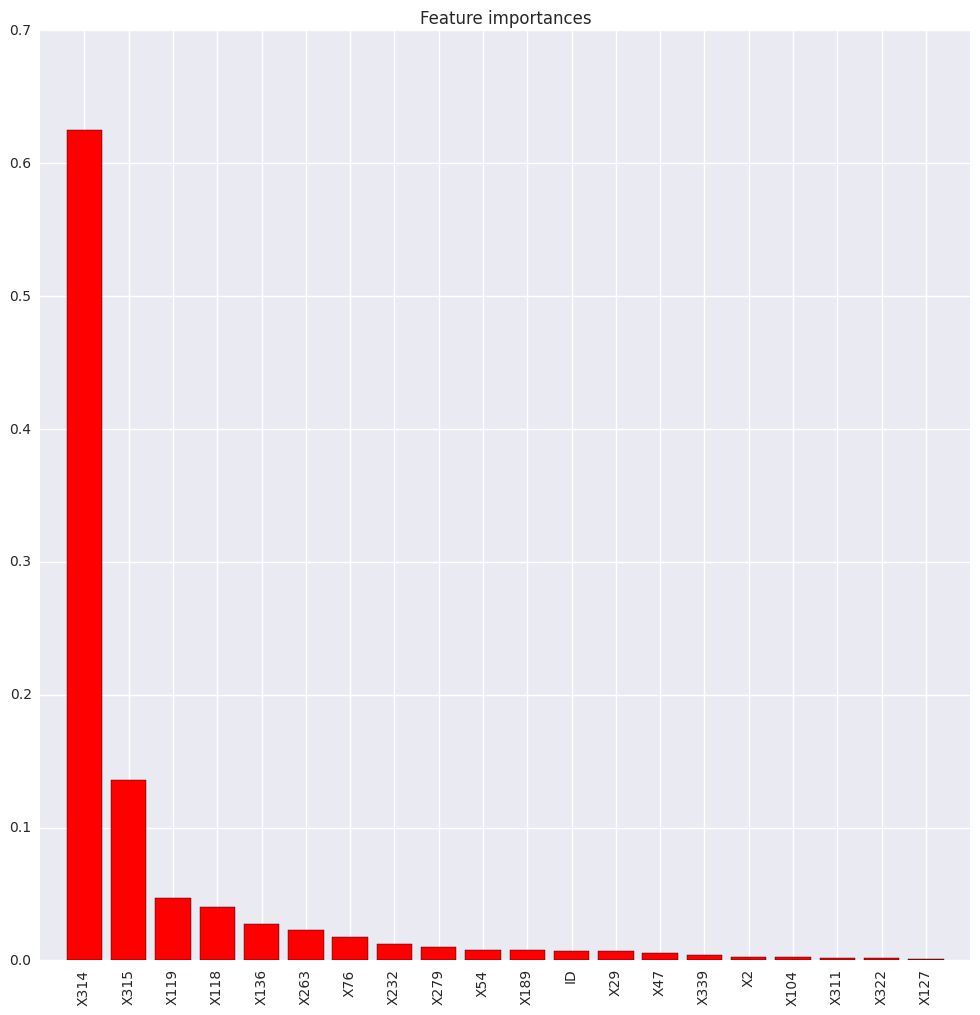

In [30]:
features = pd.DataFrame()
feat_names = train.drop(['y'],1).columns

importances = gbooster.feature_importances_
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

# Feature Engineering

In [ ]:
pca = 